# Denosing autoencoder

Simple CNN autoencoder

reference

Autoencoder implementation: 
https://gist.github.com/bigsnarfdude/dde651f6e06f266b48bc3750ac730f80

CNN autoencoder explained:
https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/

DataLoader:
https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataLoader

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!
target: 4


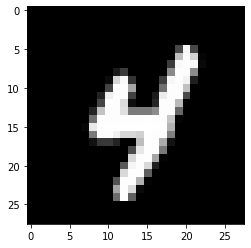

In [2]:
epochs = 40
batch_size = 128
lr = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),    
])

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=img_transform),
    batch_size=batch_size,
    shuffle=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='./data',
        train=False,
        transform=img_transform),
    batch_size=batch_size,
    shuffle=False)

# sample plot
for imgs, targets in train_loader:
    img = imgs[100, 0]  # batch x channel (1, gray) x 28 x 28
    print(f'target: {targets[100]}')
    plt.imshow(img, cmap='gray', interpolation=None)
    break

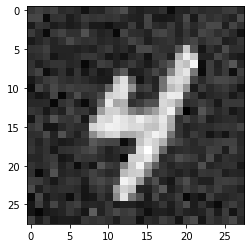

In [3]:
img += torch.randn_like(img) * 0.1
plt.imshow(img, cmap='gray')

## Model, Train

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoding, H=28
        self.conv_e1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)  # 28
        self.pool = nn.MaxPool2d(2, stride=2)  # 14
        self.conv_e2 = nn.Conv2d(16, 8, 3, stride=1)  # 12, and to 6 (pool)
        # decoding
        self.conv_d2 = nn.ConvTranspose2d(8, 16, 4, stride=2)  # 14
        self.conv_d1 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)  # 28
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv_e1(x)))
        x = self.pool(F.relu(self.conv_e2(x)))
        x = F.relu(self.conv_d2(x))
        # x = F.sigmoid(self.conv_d1(x))  # deprecated
        x = torch.sigmoid(self.conv_d1(x))
        return x
        
model = Autoencoder()
model.to(device)

Autoencoder(
  (conv_e1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_e2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv_d2): ConvTranspose2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (conv_d1): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=1e-5
)

In [6]:
from tqdm import tqdm

pbar = tqdm(range(epochs))
for epoch in pbar:  # range(epochs):
    running_loss = 0
    for imgs, _ in train_loader:  # image batch
        imgs = imgs.to(device)
        imgs_noisy = imgs + torch.randn_like(imgs) * 0.1
        # imgs_noisy = imgs.to(device)
        # =====forward==================
        outs = model(imgs_noisy)
        loss = criterion(outs, imgs)
        # =====backward=================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    pbar.set_description(f'epoch: {epoch + 1}, loss: {running_loss:.2f}')
    # print(f'epoch: {epoch + 1}, loss: {running_loss}')

epoch: 40, loss: 1.83: 100%|██████████| 40/40 [03:16<00:00,  4.92s/it]


## Sample test

target: 3


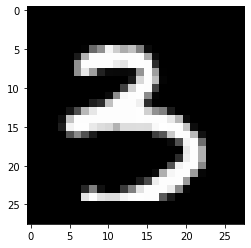

In [7]:
# sample plot
for imgs, targets in train_loader:
    img = imgs[100, 0]  # batch x channel (1, gray) x 28 x 28
    print(f'target: {targets[100]}')
    plt.imshow(img, cmap='gray', interpolation=None)
    break

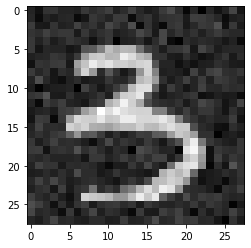

In [8]:
imgs += torch.randn_like(imgs) * 0.1
plt.imshow(img, cmap='gray')

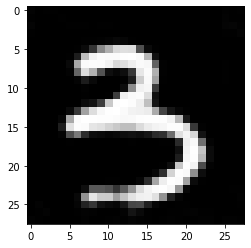

In [9]:
imgs = imgs.to(device)
outs = model(imgs)
outs = outs.cpu().detach().numpy()
plt.imshow(outs[100, 0], cmap='gray', interpolation=None)